In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.evaluate.basics import eval_model, read_saved_epochs
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data

from tf_lab.autopredictors.plotting.basics import plot_original_pclouds_vs_reconstructed, \
                                                  plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                                  plot_interpolations
                                                  


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
experiment_name = '1_virt_scan_emd_2fc_decoder_2048pts'
do_training = True
do_plotting = True
first_time_running = True
load_model = False

class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]

Give me the class type.
chair


In [4]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/2048/', class_syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/1_emd_2fc_decoder_2048pts'

In [10]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=20)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [20]:
train_id_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/shapenet_all-train.txt'
from collections import defaultdict
# a = defaultdict(lambda: "default", key="some_value")

train_data_dict = defaultdict(dict)
with open(train_id_file, 'r') as f_in:
    for line in f_in:
        syn_id, model_id = line.split()
        if len(train_data_dict[syn_id]) == 0:
            train_data_dict[syn_id] = set()
        train_data_dict[syn_id].add(model_id)        

In [25]:
len(train_data_dict[class_syn_id])

5000

In [28]:
# vscan_search_pattern = '.ply'

# virtual_scan_data = osp.join(top_data_dir, 'From_Matthias/shapenet_dim32_sdf_pc', class_syn_id)
# noisy_pcloud_files = pio.load_filenames_of_input_data(virtual_scan_data, vscan_search_pattern)


# noisy_pcloud_files[0].split('')

# def _load_virtual_scan_incomplete_pcloud_temp(f_name, n_samples=2048, vscan_search_pattern=vscan_search_pattern):
#     pc = Point_Cloud(ply_file=f_name)
#     pc.permute_points([0, 2, 1])
#     pc = pc.sample(n_samples)
#     pc.lex_sort()
#     pc.center_in_unit_sphere()
#     tokens = f_name.split('/')
#     model_id = tokens[-1][:-len(vscan_search_pattern)]
#     class_id = tokens[-2]
#     return pc.points, model_id, class_id


# noisy_pclouds, noisy_model_names, class_ids = pio.load_crude_point_clouds(file_names=noisy_pcloud_files, 
#                                                                 n_threads=22, 
#                                                                 loader=_load_virtual_scan_incomplete_pcloud_temp)

# print '%d files containing noisy point clouds were found.' % (len(noisy_pclouds), )

'/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/shapenet_dim32_sdf_pc/03001627/5874e2ea2c2b71471b356ab8b24c147__3__.ply'

In [7]:
# Match incomplete to complete data.
mapping = match_incomplete_to_complete_data(full_model_names, noisy_model_names)
full_pclouds_matched = full_pclouds[mapping]

In [8]:
train_data_, _, test_data_ = pio.train_validate_test_split([full_pclouds_matched,
                                                            noisy_pclouds, 
                                                            noisy_model_names],
                                                            train_perc=0.9,
                                                            validate_perc=0.0,
                                                            test_perc=0.1,
                                                            seed=seed)

train_data = PointCloudDataSet(train_data_[0], noise=train_data_[1], labels=train_data_[2])
test_data = PointCloudDataSet(test_data_[0], noise=test_data_[1], labels=test_data_[2])

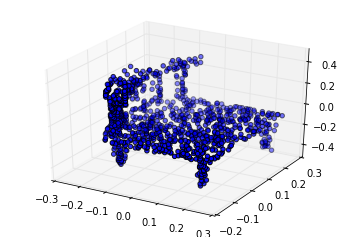

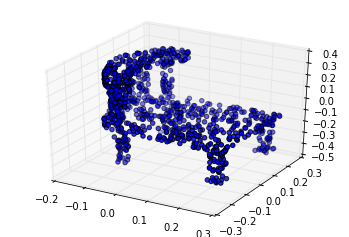

In [16]:
# TRY ME.
pp = test_data.next_batch(1)
Point_Cloud(points=pp[2].reshape(1024, 3)).plot();
Point_Cloud(points=pp[0].reshape(1024, 3)).plot();

In [18]:
if load_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:
    n_input = [2048, 3]    
    decoder_args = {'layer_sizes': [1024, np.prod(n_input)], 
                    'non_linearity': tf.nn.tanh
                   }
    encoder_args = {'symmetry': tf.reduce_sum}

    conf = Conf(
                n_input = n_input,
                denoising = True,
                training_epochs = 250,
                batch_size = 50,
                loss = 'emd',
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 10,
                learning_rate = 0.00002,
                saver_max_to_keep = 50,
                gauss_augment = {'mu': 0, 'sigma': 0.02},
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                encoder_args = encoder,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args,
               )

    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))
    print conf

In [ ]:
reset_tf_graph()
set_visible_GPUs([0])
ae = PointNetAutoEncoder(experiment_name, conf)

if do_training:
    ae.train(train_data, conf)

else:
    saved_epochs = read_saved_epochs(conf.train_dir)
    ae.restore_model(train_dir, saved_epochs[-1])

In [ ]:
if do_plotting:
    saved_epochs = read_saved_epochs(conf.train_dir)
    plot_epochs = select_first_last_and_k(saved_epochs, 13)
    stats = eval_model(ae, conf, [train_data, val_data, test_data], epochs=plot_epochs)
    last_epoch = saved_epochs[-1]
    top_save_dir = osp.join(conf.train_dir, 'model_evaluation')
    plot_train_val_test_curves(stats, top_save_dir, has_validation=True, best_epoch=None, show=True)    
    
    save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=250)
    save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=250)

# Evaluate

In [19]:
saved_epochs = read_saved_epochs(conf.train_dir)
epochs = saved_epochs[::len(saved_epochs)/20]
stats = eval_model(ae, conf, [train_data, test_data], epochs=epochs, verbose=True)

Model restored in epoch 5.
[ 0.0036257   0.00363488]
Model restored in epoch 25.
[ 0.00303681  0.00318487]
Model restored in epoch 45.
[ 0.00258437  0.00280873]
Model restored in epoch 65.
[ 0.00258048  0.00275279]
Model restored in epoch 85.
[ 0.00222897  0.00256289]
Model restored in epoch 105.
[ 0.00211788  0.00245101]
Model restored in epoch 125.
[ 0.00203812  0.00248921]
Model restored in epoch 145.
[ 0.0019052   0.00236328]
Model restored in epoch 165.
[ 0.00186296  0.0024109 ]
Model restored in epoch 185.
[ 0.0018493   0.00247049]
Model restored in epoch 205.
[ 0.0017118   0.00236473]
Model restored in epoch 225.
[ 0.00165636  0.00241264]
Model restored in epoch 245.
[ 0.00159494  0.00233725]
Model restored in epoch 265.
[ 0.00157316  0.0024386 ]
Model restored in epoch 285.
[ 0.00155867  0.00236603]
Model restored in epoch 305.
[ 0.00151814  0.00238962]
Model restored in epoch 325.
[ 0.00150176  0.00239359]
Model restored in epoch 345.
[ 0.00145065  0.00237726]
Model restored i

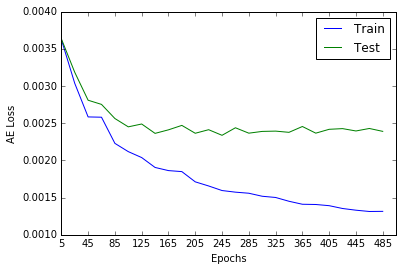

In [21]:
top_save_dir = osp.join(top_data_dir, 'OUT/model_evaluation/incomplete_pclouds/', experiment_name)
plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)

In [ ]:
last_epoch = saved_epochs[-1]
save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=100)

save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=100)